___
#### **Note for viewers by mono-glitch:**
**Sensitive/confidential data are removed, only data analytics tools used and model performance results will be displayed.**
___

# Prediction of Is Domestic Ultimate and Is Global Ultimate classifications

by NUS Datathon 2025 CAT B Team 7


# Installing dependencies required


In [ ]:
# Run these in terminal/cmd prompt if you have not done so
# %pip install scikit-learn
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install seaborn
# %pip install scipy

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from scipy.stats import zscore
import scipy
import sklearn


print("pandas version:", pd.__version__)
print("matplotlib version:", matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("scipy version:", scipy.__version__)
print("scikit-learn version:", sklearn.__version__)


---
# Importing Data + Exploratory Data Analysis (EDA)

In [ ]:
df = pd.read_csv("_.csv")
df.head()

In [ ]:
#Checking dimensions
print(df.shape)
print("")
print(df.info())
print("")
print(df.columns)

In [ ]:
#Quick summary of data
df.describe(include="all")

In [ ]:
#Categorical data
df.describe(include=[object])

In [ ]:
#Numerical Data
df.describe()

In [ ]:
print("\nNumber of duplicate rows:", df.duplicated().sum())  #No duplicates present
print("\nNumber of null rows:", df.isna().sum()) #Number of missing values

---
# Data Cleaning

1. Remove Redundant Columns:
    
    a. High Missingness/Redundancy

    - LATITUDE, LONGITUDE (x nulls; low relevance).

    - Square Footage (x nulls; too sparse unless imputed)

    - Company Status (Entirely Active, no relevance to predictions)

    - Fiscal Year End (x nulls; low relevance)

    b. Unique Identifiers/Text
    
    - AccountID, Company, Company Description  (non-predictive and redundant, company description is a detailed and repeated information when there is SIC code and description)

    c. Redundant Industry Columns

    - Industry, 8-Digit SIC Description (Irrelevant as data contained in respective SIC codes)
    

    
2. Formatting of Date/Time Columns

    - Only date-related column is Year Found, and datetime object might not be considered as the values are all in YYYY format (Encode via Label Encoding)



3. Converting data types
    
    - Use Label Encoding for low-cardinality (no. of elements) features (e.g., Ownership Type) and Frequency Encoding for high-cardinality features (e.g., 8-Digit SIC Code)
    


4. Handling missing values in columns
    - Impute missing numerical values (e.g., Year Found, Employees (Single Site)) with mean or 0

In [ ]:
#df drop columns
df = df.drop(columns=['LATITUDE', 'LONGITUDE','AccountID', 'Company', 'Industry', '8-Digit SIC Description', 'Company Description',
                      'Parent Company', 'Parent Country', 'Square Footage', 'Company Status (Active/Inactive)', 'Fiscal Year End'])


In [ ]:
#Fill NA values

#impute NA values with mean year, 0 etc.
df['Year Found'] = df['Year Found'].fillna(df['Year Found'].mean())
df['Employees (Single Site)'] = df['Employees (Single Site)'].fillna(0)
df['Employees (Domestic Ultimate Total)'] = df['Employees (Domestic Ultimate Total)'].fillna(0)
df['Employees (Global Ultimate Total)'] = df['Employees (Global Ultimate Total)'].fillna(0)

#Label encoding of Ownership type and Import/Export
EC = LabelEncoder()
#Encode the column
df['Ownership Type'] = EC.fit_transform(df['Ownership Type'])
df['Import/Export Status'] = EC.fit_transform(df['Import/Export Status'])

#Frequency Encoding of SIC codes
frequency4 = df["SIC Code"].value_counts(normalize=True)
frequency8 = df["8-Digit SIC Code"].value_counts(normalize=True)
frequencyyear = df['Year Found'].value_counts(normalize=True)

df["SIC Code"] = df["SIC Code"].map(frequency4)
df["8-Digit SIC Code"] = df["8-Digit SIC Code"].map(frequency8)
df['Year Found'] = df['Year Found'].map(frequencyyear)



In [ ]:
#Column Overview
df.head()

In [ ]:
#Checking for no more nulls
print(df.info())
print("")
print(df.columns)

---
# Visualisation of data
Outliers = Potentially Remove or Transform (Will be helpful)

Feature relationships = Identifies irrelevant features, hypothesis forming

Data quality = Correct any inconsistencies unsolved from above

>**1. Plot remaining variables against Is Domestic/ Is Global via visualisation to see correlation**  
>**2. If correlation super weak we can drop those columns as well**


In [ ]:
df.groupby('Is Domestic Ultimate')['Is Domestic Ultimate'].count()

In [ ]:
domestic = df.groupby('Is Domestic Ultimate').size()
plt.figure(figsize=(15,5))
plt.title('Domestic/Non-Domestic', size=20)
domestic.plot(kind='pie', subplots=True, autopct='%.1f%%')
plt.ylabel("Domestic")
plt.show()

50-50%: **Balanced** dataset for "Is Domestic Ultimate"

### Percentage of Global Ultimate

In [ ]:
df.groupby('Is Global Ultimate')['Is Global Ultimate'].count()

In [ ]:
Global = df.groupby('Is Global Ultimate').size()
plt.figure(figsize=(15,5))
plt.title('Global/Non-Global', size=20)
Global.plot(kind='pie', subplots=True, autopct='%.1f%%')
plt.ylabel("Global")
plt.show()

70-25%: **Imbalanced** dataset for "Is Global Ultimate", the model might struggle to learn minority class patterns (Global Ultimate =1) **Need to allow Train/Test split to keep equal class proportion**

### Company Size (Total Employees) vs Domestic/Global Ultimate

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Domestic Ultimate
sns.boxplot(x='Is Domestic Ultimate', y='Employees (Domestic Ultimate Total)', data=df, ax=axes[0])
axes[0].set_title("Employees vs. Domestic Ultimate")
axes[0].set_yscale("log")  # Log scale

# Global Ultimate
sns.boxplot(x='Is Global Ultimate', y='Employees (Global Ultimate Total)', data=df, ax=axes[1])
axes[1].set_title("Employees vs. Global Ultimate")
axes[1].set_yscale("log")  # Log scale

# Set the same y-limits for both plots, ensuring all values are positive
y_min = min(df['Employees (Domestic Ultimate Total)'][df['Employees (Domestic Ultimate Total)'] > 0].min(),
            df['Employees (Global Ultimate Total)'][df['Employees (Global Ultimate Total)'] > 0].min())
y_max = max(df['Employees (Domestic Ultimate Total)'].max(),
            df['Employees (Global Ultimate Total)'].max())

# Set limits, ensuring they are positive for log scale
axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)

plt.show()

### Sales Revenue vs Domestic/Global Ultimate

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Domestic Ultimate Sales
sns.boxplot(x='Is Domestic Ultimate', y='Sales (Domestic Ultimate Total USD)', data=df, ax=axes[0])
axes[0].set_title("Sales vs. Domestic Ultimate")
axes[0].set_yscale('log')  # Log scale for better visualization

# Global Ultimate Sales
sns.boxplot(x='Is Global Ultimate', y='Sales (Global Ultimate Total USD)', data=df, ax=axes[1])
axes[1].set_title("Sales vs. Global Ultimate")
axes[1].set_yscale('log')  # Log scale for better visualization

plt.show()

### Ownership Type vs Domestic/Global Ultimate

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Countplot for Ownership Type vs Domestic Ultimate
sns.countplot(x='Ownership Type', hue='Is Domestic Ultimate', data=df, ax=axes[0])
axes[0].set_title("Ownership Type vs Domestic Ultimate")
axes[0].set_yscale('log')  # Log scale for better visualization

# Countplot for Ownership Type vs Global Ultimate
sns.countplot(x='Ownership Type', hue='Is Global Ultimate', data=df, ax=axes[1])
axes[1].set_title("Ownership Type vs Global Ultimate")
axes[1].set_yscale('log')  # Log scale for better visualization

plt.show()

### Company Age (Year Found) vs Domestic/Global Ultimate

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for Year Found vs Domestic Ultimate
sns.boxplot(x='Is Domestic Ultimate', y='Year Found', data=df, ax=axes[0])
axes[0].set_title("Year Found vs Domestic Ultimate")
axes[0].set_yscale('log')  # Log scale for better visualization

# Boxplot for Year Found vs Global Ultimate
sns.boxplot(x='Is Global Ultimate', y='Year Found', data=df, ax=axes[1])
axes[1].set_title("Year Found vs Global Ultimate")
axes[1].set_yscale('log')  # Log scale for better visualization

plt.show()

### SIC Code (Industry) vs Domestic/Global Ultimate

In [ ]:
# Limit to top 10 SIC Codes by count
top_n = 10

# Get the top N SIC Codes
top_sic_codes = df['SIC Code'].value_counts().head(top_n).index

# Filter the data to only include top SIC Codes
filtered_df = df[df['SIC Code'].isin(top_sic_codes)]

# Create subplots to display the two countplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Countplot for SIC Code vs Domestic Ultimate (Top N SIC Codes)
sns.countplot(x='SIC Code', hue='Is Domestic Ultimate', data=filtered_df, palette='Set1', ax=axes[0])
axes[0].set_title("Top SIC Codes vs Domestic Ultimate")
axes[0].tick_params(axis='x', rotation=45)

# Countplot for SIC Code vs Global Ultimate (Top N SIC Codes)
sns.countplot(x='SIC Code', hue='Is Global Ultimate', data=filtered_df, palette='Set2', ax=axes[1])
axes[1].set_title("Top SIC Codes vs Global Ultimate")
axes[1].tick_params(axis='x', rotation=45)

# Display the plots
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

### Import/Export Status vs Domestic/Global Ultimate

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(x='Import/Export Status', hue='Is Domestic Ultimate', data=df, ax=axes[0])
axes[0].set_title("Import/Export Status vs Domestic Ultimate")
axes[0].set_yscale('log')  # Log scale for better visualization


sns.countplot(x='Import/Export Status', hue='Is Global Ultimate', data=df, ax=axes[1])
axes[1].set_title("Import/Export Status vs Global Ultimate")
axes[1].set_yscale('log')  # Log scale for better visualization

plt.show()

['Both Imports & Exports', 'Exports', 'Imports', 'None']

### Correlation Heatmap
>Find which features correlate with Domestic & Global Ultimate  
>High Correlation are important for prediction

In [ ]:
# Convert categorical features to numeric if necessary
df_encoded = df.copy()
df_encoded['Ownership Type'] = df_encoded['Ownership Type'].astype('category').cat.codes

# Compute correlation
corr = df_encoded.corr()

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

Numerical Variables (Employees x Sales)

In [ ]:
# Correlation Heatmap
corr = df[['Employees (Single Site)', 'Employees (Domestic Ultimate Total)',
           'Employees (Global Ultimate Total)', 'Sales (Domestic Ultimate Total USD)',
           'Sales (Global Ultimate Total USD)']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Employees vs Sales")
plt.show()

### Histogram

In [ ]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

In [ ]:
# Histograms for numerical columns
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col].sample(frac=0.1, random_state=42), bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()
    plt.close()  # Free up memory

---
# Data Preprocessing and Splitting

Handling Outliers

Train Test Validation Split

All testing will be done on our validation data (eg. hyperparameter tuning)

### Outliers

In [ ]:
#Calculating total number of outliers in each variables
for var in numerical_columns:
    print(f'Outliers in {var}: {len(df[df[var] > df[var].mean() + 2 * df[var].std()])}')
    print(f'Outliers in {var}: {len(df[df[var] < df[var].mean() + 2 * df[var].std()])}')


In [ ]:
#Counting outliers using z-score
for var in numerical_columns:
    print(f'Outliers in {var}: {np.sum(np.abs(zscore(df[var].dropna())) > 3)}')


In [ ]:
# Removing outliers using SD method
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

for var in numerical_columns:

    mean = df[var].mean()
    std_dev = df[var].std()

    # Define the thresholds (mean ± 3 * std_dev, lower bound is not necessary))
    upper_threshold = mean + 3 * std_dev

    df_cleaned = df[(df[var] <= upper_threshold)]

    print(f"Number of outliers removed for {var}: {df.shape[0] - df_cleaned.shape[0]}")
    print(f"Remaining data points for {var}: {df_cleaned.shape[0]}")

    df = df_cleaned





In [ ]:
print(df.columns)

### Train Test Validation Split for Domestic Ultimate / Global Ultimate (Separated)

Split into 70% Training Data, 10% Validation Data, 20% Test Data

#### Train 1: Is Domestic Ultimate

In [ ]:
# Define features (X) and target (y) for Domestic Ultimate
X = df[['SIC Code', '8-Digit SIC Code', 'Year Found', 'Ownership Type',
       'Employees (Single Site)', 'Employees (Domestic Ultimate Total)',
       'Employees (Global Ultimate Total)',
       'Sales (Domestic Ultimate Total USD)',
       'Sales (Global Ultimate Total USD)', 'Import/Export Status']]  # features
y1 = df['Is Domestic Ultimate']  # target variable

# Split dataset into train and temp (test + validation)
X_train1, X_temp1, y_train1, y_temp1 = train_test_split(X, y1, test_size=0.3, random_state=42, stratify=y1)

# Split temp into validation and test
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_temp1, y_temp1, test_size=2/3, random_state=42, stratify=y_temp1)

# 7. (Optional) Verify the sizes of the splits
print("Training set:", X_train1.shape, y_train1.shape)
print("Validation set:", X_val1.shape, y_val1.shape)
print("Test set:", X_test1.shape, y_test1.shape)

#### Train 2: Is Global Ultimate

In [ ]:
# Define features (X) and target (y) for Global Ultimate

y2 = df['Is Global Ultimate']  # target variable

# Split dataset into train and temp (test + validation)
X_train2, X_temp2, y_train2, y_temp2 = train_test_split(X, y2, test_size=0.3, random_state=42, stratify=y2)

# Split temp into validation and test
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_temp2, y_temp2, test_size=2/3, random_state=42, stratify=y_temp2)

# 7. (Optional) Verify the sizes of the splits
print("Training set:", X_train2.shape, y_train2.shape)
print("Validation set:", X_val2.shape, y_val2.shape)
print("Test set:", X_test2.shape, y_test2.shape)

---
# ML Model Training

Supervised Categorical Prediction task: Random Forest

#### Validation for Is Domestic Ultimate

In [ ]:
# Initialize the Decision Tree model
rf_clf1 = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=20, min_samples_split=10, n_jobs = -1)

# Fit the model on training data
rf_clf1.fit(X_train1, y_train1)

# Make predictions on validation data
y_predrf1 = rf_clf1.predict(X_val1)

# Compare the true label and predicted label
df_results = pd.DataFrame({'Actual': y_val1, 'Predicted': y_predrf1})
print(f'Predicted {(df_results["Actual"] == df_results["Predicted"]).sum()} out of {df_results.shape[0]}')
print(f"Accuracy: {round(accuracy_score(df_results['Actual'], df_results['Predicted']), 3)}")


Predicted 2663 out of 2918,
Accuracy: 0.913\
(n_estimators=100, random_state=42, max_depth=20, min_samples_split=10, n_jobs = -1)

Predicted 2662 out of 2918,
Accuracy: 0.912\
(n_estimators=300, random_state=42, max_depth=20, min_samples_split=10, n_jobs = -1)

Predicted 2663 out of 2918,
Accuracy: 0.913\
(n_estimators=300, random_state=42, max_depth=20, min_samples_split=10, n_jobs = -1) (prolly overfitting at this point)

In [ ]:
# Get feature importance for Domestic Ultimate
feature_importance = rf_clf1.feature_importances_

# Create a DataFrame for better readability
features = ['SIC Code', '8-Digit SIC Code', 'Year Found', 'Ownership Type',
       'Employees (Single Site)', 'Employees (Domestic Ultimate Total)',
       'Employees (Global Ultimate Total)',
       'Sales (Domestic Ultimate Total USD)',
       'Sales (Global Ultimate Total USD)', 'Import/Export Status']
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted feature importances
#print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Domestic Ultimate: Feature Importance')
plt.show()

#### Validation for Is Global Ultimate

In [ ]:
# Fit the model on training data
rf_clf2 = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=20, min_samples_split=10, n_jobs = -1)
rf_clf2.fit(X_train2, y_train2)

# Make predictions on validation data
y_predrf2 = rf_clf2.predict(X_val2)

# Compare the true label and predicted label
df_results2 = pd.DataFrame({'Actual': y_val2, 'Predicted': y_predrf2})
print(f'Predicted {(df_results2["Actual"] == df_results2["Predicted"]).sum()} out of {df_results2.shape[0]}')
print(f"Accuracy: {round(accuracy_score(df_results2['Actual'], df_results2['Predicted']), 3)}")

Predicted 2762 out of 2918,
Accuracy: 0.947\
(n_estimators=100, random_state=42, max_depth=20, min_samples_split=10, n_jobs = -1)

Predicted 2763 out of 2918,
Accuracy: 0.947\
(n_estimators=300, random_state=42, max_depth=20, min_samples_split=10, n_jobs = -1)

Predicted 2763 out of 2918,
Accuracy: 0.947\
(n_estimators=500, random_state=42, max_depth=20, min_samples_split=10, n_jobs = -1)


In [ ]:
# Get feature importance for Global Ultimate
feature_importance = rf_clf2.feature_importances_

# Create a DataFrame for better readability
features = ['SIC Code', '8-Digit SIC Code', 'Year Found', 'Ownership Type',
       'Employees (Single Site)', 'Employees (Domestic Ultimate Total)',
       'Employees (Global Ultimate Total)',
       'Sales (Domestic Ultimate Total USD)',
       'Sales (Global Ultimate Total USD)', 'Import/Export Status']
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted feature importances
#print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Global Ultimate: Feature Importance')
plt.show()

---
# Model Evaluation

Testing against Test Data, calculating Accuracy, Precision, Recall, F1-Score, Plot ROC curve and calculate AUC\
Check goodness of fit of model via confusion matrix

#### Test for Is Domestic Ultimate

In [ ]:
#Checking against Test data for Domestic Ultimate
y_predrf1 = rf_clf1.predict(X_test1)

df_results1test = pd.DataFrame({'Actual': y_test1, 'Predicted': y_predrf1})
print(f'Predicted {(df_results1test["Actual"] == df_results1test["Predicted"]).sum()} out of {df_results1test.shape[0]}')

Predicted 5008 out of 5450


#### Test for Is Global Ultimate

In [ ]:
#Checking against Test data for Global Ultimate
y_predrf2 = rf_clf2.predict(X_test2)

df_results2test = pd.DataFrame({'Actual': y_test2, 'Predicted': y_predrf2})
print(f'Predicted {(df_results2test["Actual"] == df_results2test["Predicted"]).sum()} out of {df_results2test.shape[0]}')

Predicted 5119 out of 5450


### Accuracy, Precision, Recall, and F1-Score + ROC Curve and AUC

Is Domestic Ultimate:
Accuracy: 0.919
Precision: 0.891
Recall: 0.954
F1-Score: 0.921
ROC-AUC: 0.962


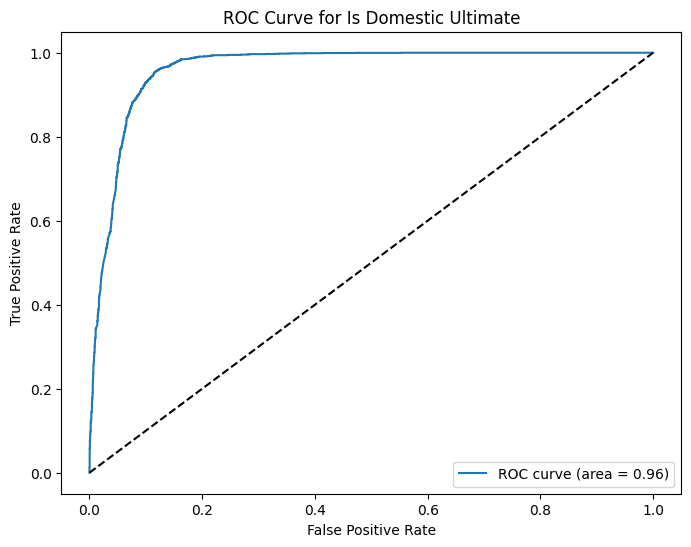

Is Global Ultimate:
Accuracy: 0.939
Precision: 0.857
Recall: 0.919
F1-Score: 0.887
ROC-AUC: 0.977


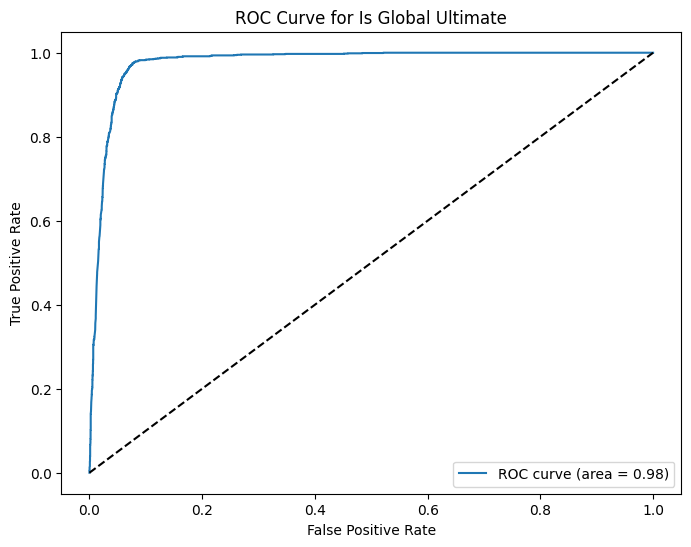

In [ ]:
# Function to calculate metrics and plot ROC curve
def evaluate_model(y_true, y_pred, y_pred_proba, title):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    print(f"Accuracy: {round(accuracy, 3)}")
    print(f"Precision: {round(precision, 3)}")
    print(f"Recall: {round(recall, 3)}")
    print(f"F1-Score: {round(f1, 3)}")
    print(f"ROC-AUC: {round(roc_auc, 3)}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {title}')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate Domestic Ultimate model
y_pred_proba1 = rf_clf1.predict_proba(X_test1)[:, 1]
print("Is Domestic Ultimate:")
evaluate_model(y_test1, y_predrf1, y_pred_proba1, "Is Domestic Ultimate")

# Evaluate Global Ultimate model
y_pred_proba2 = rf_clf2.predict_proba(X_test2)[:, 1]
print("Is Global Ultimate:")
evaluate_model(y_test2, y_predrf2, y_pred_proba2, "Is Global Ultimate")



### Precision-Recall Curve for Is Global Ultimate
for imbalanced dataset

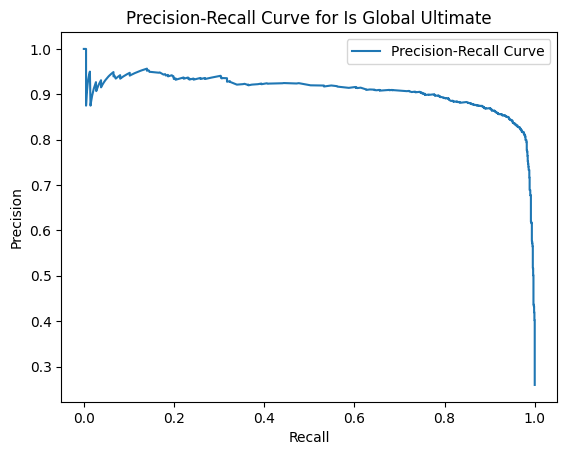

In [ ]:
precision, recall, _ = precision_recall_curve(y_test2, y_pred_proba2)
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Is Global Ultimate')
plt.legend()
plt.show()

High Precision and High Recall

### Confusion Matrix
>Detailed breakdown of how well a classifciation model is performing  
>Compares predicted labels with true labels (shows right and wrong)

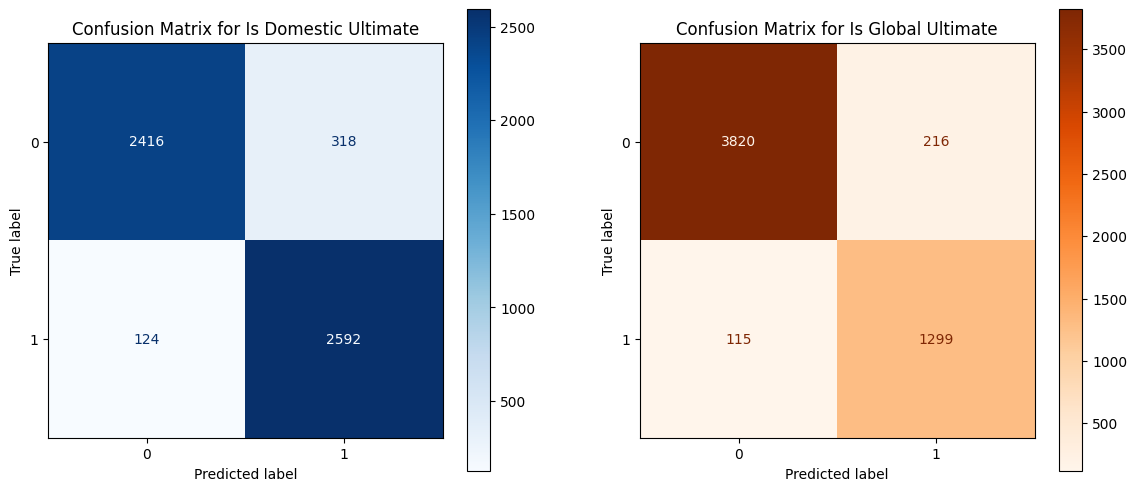

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cm1 = confusion_matrix(y_test1, y_predrf1)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)

# Second Confusion Matrix (you can replace with another model or test data)
cm2 = confusion_matrix(y_test2, y_predrf2)  # Replace this with another model's predictions if needed
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)

# Plot first confusion matrix
disp1.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix for Is Domestic Ultimate')

# Plot second confusion matrix
disp2.plot(ax=axes[1], cmap='Oranges')
axes[1].set_title('Confusion Matrix for Is Global Ultimate')

plt.show()